# Face Detection and Gender Classification using CNN's

The human's sense of sight and the brain's ability to instantaneously classify a miriad of objects is an outstanding feat. Having the ability to isolate an object within our vision from a variety of angles and then being able to classify is a feat which until very recently was impossible to mimic with even the most sophisticated computers.

This project will attempt to create a simple yet effective system that will take in an image and identify not only the faces in the image but also to predict the gender of the faces detected. 

Applications for such an algorithm can come in a wide variety of problems. Social media platforms can use such an algorithm as a preliminary filter when automatically tagging people. Perhaps given a large gathering that has video or image available, one could attempt to approximate the distribution of male to females in attendance. Maybe some robot receptionist that might exist somewhere would be able to greet people with "Hello sir" or a "Hello madam" based on the gender of the person approaching them.





### Libraries
For this project we will be utilizing OpenCV for facial recognition, sklearn for machine learning, and keras for the neural network. All libraries are powerful and easy to use, abstracting away the lower level details.

### Data Collection
In order to train our machine learning model we need pre-labeled datasets. We are going to need an image set of men and a separate image set of women. To obtain these images we will use a python Flickr API wrapper that allows a user to search for images on Flickr's database and save them to your machine. The code found in flickr_download.py downloads images from flickr database given a search string and api keys. (Note you need to have flickr_api installed which can be done with 'pip install flickr_api') 

However a lot, if not most of the images returned by Flickr will be unusable either because the entire face of the person cannot be seen or the image contains no face at all. Here is an example of an image returned by Flickr when searching female portrait:  ![title](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/img/30415073503.jpg) 

Therefore we will have to manually filter the returned images for suitable photos for training.


### Data Preprocessing
To help with the manual sorting of the images we have written a script that displays each image and the user can classify each image by using the keyboard, e.g. right arrow for a male photo, left arrow for a female photo, up arrow for an unusable photo. The implementation can be found in the script sort_images.py.

From the ~8000 photos we downloaded off of Flickr, around 2000 turned out to be usable for our training set. Although more images would be ideal for training, we simply did not have the time to manually filter out more images.


Once we have all of the images sorted it is time to process them. Taking a quick glance out our preprocessed photos most of the images are body shots of a person. Since our classifier will classify gender based on facial features it makes sense to extract only the faces from the images. To help with this task we will use OpenCv's facial recognition features to identify the bounding box of the faces in the images and use this information to automatically crop out the face. The code for this process can be found in auto_crop.py.
Uncropped image: ![title](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/img/6750839791.jpg)

Cropped image: ![title](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/img/6750839791_cropped.jpg)

After the faces have been cropped it is time for another round of manual sorting. Although Opencv's facial recognition software works fairly well, there are still some outliers in the dataset. We will get rid of these outliers in the same way we sorted the photos out using the sort_images.py script. After this step we are left with ~1600 face photos.

The next task in our data preprocessing pipeline is normalizing the photos. The code for this section can be found in resizeAndGrayscale.py and which as its name suggests, resizes all the processed images to be 75 x 75 pixels and grayscales them. This is the final step in preprocessing our data and now that we have a collection of normalized we can move on to actually training on our dataset.


In [112]:
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from PIL import Image, ImageDraw, ImageFont
import numpy as np

import os
import copy
import time

from autocrop import *
from resizeAndGrayscale import *
import cv2

### Extracting Features

Now that we have all of our data nice and processed it is time to extract the features. For this we are going to use the pretrained VGG-16 model. We will use Keras to build our model and extract the feature information. For our model we chose to use the adam optimize because compared to other gradient descent algorithms because it accounts for changes better than other naive gradient descent algorithms and is generally faster by using momentum. The code can be found in vgg16.py

Running on a Macbook Air the feature extraction takes about 10-15 min on ~1600 75 x 75 photos.


In [113]:
from vgg16 import *
truncated_vgg = VGG_16("vgg16_weights.h5")

In [114]:
females = map(lambda path: "female_cropped_normalized-flickr/"+path, os.listdir("female_cropped_normalized-flickr-resized-50x50"))
males = map(lambda path: "male_cropped_normalized-flickr/"+path, os.listdir("male_cropped_normalized-flickr-resized-50x50"))
files = copy.copy(females)
files.extend(males)
files = filter(lambda path: path.find("jpg") > -1, files)

In [24]:
def data_to_vgg_input(data):
    if data.mode != "RGB":
        data = data.convert(mode="RGB")
    return np.rollaxis(np.asarray(data),2)

def fname_to_vgg_input(fname):
    im = Image.open(fname)
    return data_to_vgg_input(im)


def fnames_to_features(fnames, vgg):
    vgg.compile(optimizer="adam", loss='categorical_crossentropy')
    vgg_input = map(lambda fname: fname_to_vgg_input(fname), fnames)
    return vgg.predict(np.asarray(vgg_input))

inp = files

thing2 = fnames_to_features(inp, truncated_vgg)

np.savetxt("features_flickr", thing2)
labels = map(lambda path: path.find("female")> -1, inp)
np.savetxt("labels_flickr", np.asarray(labels))
    

In [82]:
features = np.loadtxt("features_yearbook.txt")
labels = np.loadtxt("labels_yearbook.txt", dtype=float).astype(int)

# The Classifier

For classification, the easiest way to figure out what might work better than others was to simply try a good number of them. We've decided to limit our loss functions to log, hinge, perceptron and modified_huber. The first three are due to them being widely used and generally good bets when training linear classifiers. Modified huber is also tried due to its nature of being less sensitive to outliers, which are naturally present in a data set of nature such as faces from random images.

In [84]:
perm = np.random.permutation(len(labels))
perm = perm
numberToTrainOn = int(len(perm)*0.8)

X_tr = features[perm[:numberToTrainOn]]
y_tr = labels[perm[:numberToTrainOn]]
X_va = features[perm[numberToTrainOn:]]
y_va = labels[perm[numberToTrainOn:]]

def make_model(X, y, loss="log", penalty="l2"):
    from sklearn.linear_model import SGDClassifier
    clf = SGDClassifier(loss=loss, penalty=penalty)
    clf.fit(X, y)
    return clf

params = [["log", "l2"], ["log", "l1"], ["log", "none"], ["log", "elasticnet"],
          ["modified_huber", "l2"], ["modified_huber", "l1"], ["modified_huber", "none"], ["modified_huber", "elasticnet"], 
          ["hinge", "l2"],  ["hinge", "l1"], ["hinge", "none"], ["hinge", "elasticnet"],
          ["perceptron", "l2"], ["perceptron", "l1"], ["perceptron", "none"], ["perceptron", "elasticnet"]]


numIters = 100
for param in params:
    runs = []
    for i in xrange(numIters):
        start = time.time()
        classifier = make_model(X_tr, y_tr, param[0], param[1])
        y_p = classifier.predict(X_va)
        end = time.time()
        runs.append((np.mean(y_p==y_va), end-start))

    acc = reduce(lambda x,y:x+y, map(lambda z: z[0], runs))/len(runs)
    runtime = reduce(lambda x,y:x+y, map(lambda z: z[1], runs))/len(runs)
    print "--------- {} Iters -----------".format(numIters)
    print "Loss function: ", param[0]
    print "Penalty:       ", param[1]
    print "Avg Accuracy:  ", acc
    print "Avg runtime:   ", runtime


```For parameters:
params = [["log", "l2"],              ["log", "l1"], 
          ["log", "none"],            ["log", "elasticnet"],
          ["modified_huber", "l2"],   ["modified_huber", "l1"], 
          ["modified_huber", "none"], ["modified_huber", "elasticnet"], 
          ["hinge", "l2"],            ["hinge", "l1"], 
          ["hinge", "none"],          ["hinge", "elasticnet"],
          ["perceptron", "l2"],       ["perceptron", "l1"], 
          ["perceptron", "none"],     ["perceptron", "elasticnet"]]

Trained on ~1400 images and tested on ~200.

Output:
--------- 500 Iters -----------
Loss function:  log
Penalty:        l2
Avg Accuracy:   0.830854599407
Avg runtime:    0.0430937166214
--------- 500 Iters -----------
Loss function:  log
Penalty:        l1
Avg Accuracy:   0.850296735905
Avg runtime:    0.144080107689
--------- 500 Iters -----------
Loss function:  log
Penalty:        none
Avg Accuracy:   0.851121661721
Avg runtime:    0.0362924733162
--------- 500 Iters -----------
Loss function:  log
Penalty:        elasticnet
Avg Accuracy:   0.833732937685
Avg runtime:    0.16214424324
--------- 500 Iters -----------
Loss function:  modified_huber
Penalty:        l2
Avg Accuracy:   0.832142433234
Avg runtime:    0.0401724615097
--------- 500 Iters -----------
Loss function:  modified_huber
Penalty:        l1
Avg Accuracy:   0.850314540059
Avg runtime:    0.13827644062
--------- 500 Iters -----------
Loss function:  modified_huber
Penalty:        none
Avg Accuracy:   0.848747774481
Avg runtime:    0.0362318944931
--------- 500 Iters -----------
Loss function:  modified_huber
Penalty:        elasticnet
Avg Accuracy:   0.835620178042
Avg runtime:    0.15857756424
--------- 500 Iters -----------
Loss function:  hinge
Penalty:        l2
Avg Accuracy:   0.831008902077
Avg runtime:    0.05214802742
--------- 500 Iters -----------
Loss function:  hinge
Penalty:        l1
Avg Accuracy:   0.851216617211
Avg runtime:    0.145944835186
--------- 500 Iters -----------
Loss function:  hinge
Penalty:        none
Avg Accuracy:   0.851204747774
Avg runtime:    0.0378437142372
--------- 500 Iters -----------
Loss function:  hinge
Penalty:        elasticnet
Avg Accuracy:   0.834456973294
Avg runtime:    0.158988286495
--------- 500 Iters -----------
Loss function:  perceptron
Penalty:        l2
Avg Accuracy:   0.83249851632
Avg runtime:    0.0361666822433
--------- 500 Iters -----------
Loss function:  perceptron
Penalty:        l1
Avg Accuracy:   0.851293768546
Avg runtime:    0.146597042561
--------- 500 Iters -----------
Loss function:  perceptron
Penalty:        none
Avg Accuracy:   0.850670623145
Avg runtime:    0.0369562048912
--------- 500 Iters -----------
Loss function:  perceptron
Penalty:        elasticnet
Avg Accuracy:   0.834658753709
Avg runtime:    0.161072585106
```

Seeing the above, we might be able to notice a pattern in the accuracies. It appears that the accuracy is mostly influenced by the penalty and not the loss function. We'll notice that L1 and the lack of a penalty seem to all yield accuracies in the ~85% range. While we will not dive into the deeper analyses behind this, one might consider things such as the face detection and cropping algorithm used. Perhaps due to the nature of image processing being an "ill-posed problem", regularization functions such as L2 are better suited for them. This of course begs the question however that if this is the case, why does having no penalty function seem to behave equally well? This would seem to be counter-intuitive to our expectation.



# Loading the Features

We will use two different sets of features and labels for our final algorithm. The data was collected as follows:

1. We use images scraped from flickr using their api. This dataset consists of about 1600 images. About 50/50 split on male to female.

2. For sake of comparison, we will also use a highly regular dataset of yearbook photos. We expect that this will perform worse than our generalized images due to the nature of yearbook photos all being highly regular (eg smiling, face straight, good angle). Naturally, this will be bad when trying to classify images that are likely going to be taken from a variety of angles, expressions and other variances.

Given the results of the previous section, we will use the log loss function with an l1 regularization function.

In [86]:
features_yrbk = np.loadtxt("features_yearbook.txt")
labels_yrbk = np.loadtxt("labels_yearbook.txt", dtype=float).astype(int)

In [116]:
features_owndata = np.loadtxt("features.txt")
labels_owndata = np.loadtxt("labels.txt", dtype=float).astype(int)

In [120]:
clf_yrbk = make_model(features_yrbk, labels_yrbk, "log", "l2")
clf_owndata = make_model(features_owndata, labels_owndata, "perceptron", "l1")

vgg = truncated_vgg
vgg.compile(optimizer="adam", loss='categorical_crossentropy')

# Tying it all together

Now that we have a method for detecting and cropping out faces as well as a feature extraction system and a classifier, we can tie all of these together in one final function that will, given some image, detect, highlight and guess the gender and label it. Effectively, all we are doing here are pipelining the various algorithms we've already introduced. 


As a recap here are all the steps taken to classify genders in an image using our full data pipeline:
1. Extract faces from given image
2. Normalize the extracted faces
3. Convert the faces into an array to be used as an input to the vgg model
4. Extract the features using the vgg model
5. Feed features into trained classifier
6. Extract the labels from the classifier
7. Classify the faces in image using the labels

Normalizing <PIL.Image._ImageCrop image mode=RGB size=53x53 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=40x40 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=52x52 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=56x56 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=45x45 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=60x60 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=60x60 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=54x54 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=58x58 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=59x59 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=60x60 at 0x1080BEF38>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=68x68 at 0x10EAE00E0>
Normalizing <PIL.Image._ImageCrop image mode=RGB size=59x59 at 0x1080BEF38>
Normalizing 

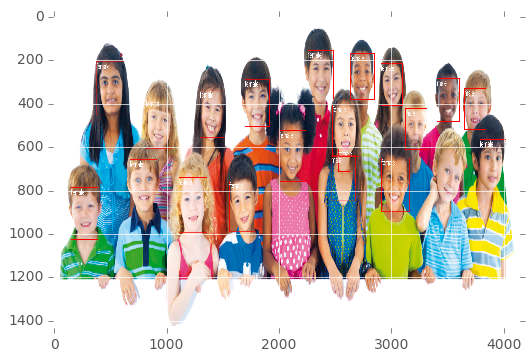

In [121]:
def plot_image(im):
    try:
        plt.imshow(im, aspect='auto')
    except:
        plt.imshow(np.asarray(im[:,:]))
    
def drawRectangle(drawer, coords, width):
    ((x1,y1),(x2,y2)) = coords
    for i in xrange(width):
        drawer.rectangle(((x1+i,y1+i),(x2-i,y2-i)), outline="red")
    
faceCascade = cv.Load('haarcascade_frontalface_alt.xml')
def faceCrop(imPath,boxScale=1):
    classifier = clf_owndata
    #classifier = clf_yrbk
    
    im = Image.open(imPath)
    finalImage = Image.open(imPath)
    
    faces = []
    cv_im=pil2cvGrey(im)
    faces=DetectFace(cv_im,faceCascade)
    if faces:
        n=1
        drawer = ImageDraw.Draw(finalImage)

        for face in faces:
            faceData = imgCrop(im, face[0],boxScale=boxScale)
            normalized = crop_and_scale_image(faceData, minimum=75, isPath=False)
            
            if normalized == None:
                # passed in image was invalid/too small. Skip.
                continue
            
            vgg_input = np.array([data_to_vgg_input(normalized)])
            prediction = classifier.predict(vgg.predict(vgg_input))
            prediction = "female" if prediction>0 else "male"
            ((x,y,w,h),n) = face
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h)) 

            drawRectangle(drawer, (pt1,pt2), 3)
            fnt = ImageFont.truetype('Arial', 40)
            drawer.text(pt1, prediction, font=fnt, fill=(255,255,255,255))
        
        plot_image(finalImage)
        savePath = imPath.split("/")
        savePath[0] = savePath[0]+"-output"
        folderPath = "/".join(savePath[:-1])
        savePath = "/".join(savePath)
        if not os.path.isdir(folderPath):
            os.mkdir(folderPath)
            
        print "Saving: ", savePath
        finalImage.save(savePath)
            
            
    else:       
        print 'No faces found:', imPath

testImage = "testImages/testImage4.png"

testImages = os.listdir("testImages")
testImages = map(lambda path: "testImages/"+path, testImages)
testImages = filter(lambda path: path.find("png") > -1 or path.find("jpg") > -1, testImages)
for path in testImages:
    faceCrop(path)


# Results

## Top is with self-collected dataset. Bottom is pre-curated yearbook dataset


testImage1.jpg
![](testImages-output/testImage1.jpg)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage1.jpg)

testImage2.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage2.jpg)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage2.jpg)

testImage3.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage3.jpg)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage3.jpg)

testImage4.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage4.png)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage4.png)

testImage5.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage5.png)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage5.png)

testImage6.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage6.jpg)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage6.jpg)

testImage7.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage7.png)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage7.png)

testImage8.jpg
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output/testImage8.jpg)
![](https://raw.githubusercontent.com/remiscarlet/15388-Final-Project/master/testImages-output-yrbk/testImage8.jpg)


# Statistics

**Image 1:**  
 Faces: 1  
 owndata: 100% (1/1)  
 yrbkdata: 100% (1/1)  
  
**Image 2:**  
 Faces: 5  
 owndata: 100% (5/5)  
 yrbkdata: 100% (5/5)  
  
**Image 3:**  
 Faces: 19  
 owndata: 89% (17/19)  
 yrbkdata: 84% (16/19)  
  
**Image 4:**  
 Faces: 12  
 owndata: 100% (12/12)  
 yrbkdata: 100% (12/12)  
  
**Image 5:**  
 Faces: 14  
 owndata: 86% (12/14)  
 yrbkdata: 36% (5/14)  
  
**Image 6:**  
 Faces: 11  
 owndata: 63% (7/11)  
 yrbkdata: 72% (8/11)  
  
**Image 7:**  
 Faces: 7  
 owndata: 100% (7/7)  
 yrbkdata: 100% (7/7)  
  
**Image 8:**  
 Faces: 18  
 owndata: 56% (10/18)  
 yrbkdata: 61% (11/18)  
  
## Aggregate Statistics:
 Faces: 87  
 owndata: 81% (71/87)  
 yrbkdata: 67% (58/87)  
  


# Observations on the pre-curated dataset versus our own gathered data.

The first thing we might notice is that the yearbook dataset has a considerably lower overall accuracy than the data we gathered on our own. A 14% difference simply based on the training data is quite significant. 

Observing the results individually however, we can notice that there are a few images where the yearbook data performs better than our own training data. Notably, image 6 and image 8.

Observing image 6, most of the faces that are mislabeled are asian in descent. Looking at our training data, we actually realize that the vast majority of the male images are of caucasians or african americans. This bias is likely the cause of our error. 

Observing image 8, an image of only children, we notice that again that after looking at our training data, the overall age of the individuals in the yearbook data are overall younger. Perhaps this bias also influenced the data.

# Notable Drawbacks

## We will only talk about our own dataset. Not the pre-curated yearbook one.

Likely the greatest drawback to our algorithm is the fact that we trained on data of size at last 75x75 pixels. This means that for any "face" that is smaller than that size, we can either discard it (Eg, pretend it's not a face) or attempt to upscale the image and classify based on the upscaled image. We opted for the former since it is simpler, but it is likely easy to imagine why accuracy on the latter option would be less than ideal. This limitation of "face size" also results in us not being able to classify images whose base resolution is not high. This drawback is easiest to notice when looking at testImage1. The face detection algorithm detects 20 faces, yet due to all but one of them being smaller than the required 75x75 size limitation, the labeled image only has one labeled face.

Another drawback is due to our limited training data. Having only trained on ~1600 images all coming from flickr, our data is likely biased in certain ways. Flickr tends to have photos which are more posted to be appreciated due to their artistic quality and as such have preparation such as lighting, filters, angles and multiple tries per photo. This means that it might corelate poorly to the average photo taken of some people doing whatever they're doing. Another issue is that our data consisted almost entirely of adults. We can notice that this manifested in a lot of error in testImage8 where almost all the boys were labeled as females. This can easily be attributed to the fact that children tend to have more feminine-like features such as "softer" faces.

# Conclusion

This project showcased the power of existing machine learning libraries and what you can build with them. The fact that we only had 1600 photos to train our classifier yet achieved reasonable accuracy is remarkable. The same principles that this project is built on could be used to implement something more complex such as age classification.


### Summary and References
1. Scikit-learn: http://scikit-learn.org/stable/
2. Keras: https://keras.io/
3. OpenCV: http://opencv.org
4. Python Flickr Api Wrapper: https://github.com/alexis-mignon/python-flickr-api
5. Yearbook Dataset: https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html